<hr>


<span style="font-size:32px"><b>Apprentice Chef --- Cross-Selling Prediction Modeling</b></span><br><br>
<br>
<span style="font-size:28px"><b>Supervised Machine Learning </b></span><br>
<br>
<span style="font-size:18px">Jiehui Lin, MSBA</span><br>
<br>
<span style="font-size:18px">[GitHub](https://github.com/JiehuiL906)</span><br>
<br>
<span style="font-size:18px">Hult International Business School <span><br>

    
    
<hr>
<hr>

<b>Objective:</b>
<ul>
<li>Examine what are significant factors that promote cross-selling of a half bottle of wine to customers </li>
<li>Build machine learning model to predict which customers will subscribe cross-selling service</li>
</ul>

<b>Presumption:</b>
<ul>
<li> The customers either subscribe cross-selling wine or not (binary outcome 1 or 0) </li>
<li> A cleaned data set of approx 2000 customers is statistically sound and representative </li>
</ul>    

<h4><b>Data Loading and Verifying </h4><b>

In [1]:
# importing libraries
import random            as rand                     # random number gen
import numpy             as np                       # numpy
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.metrics import roc_auc_score            # auc score
import statsmodels.formula.api as smf
import gender_guesser.detector as gender 

#libraries for classification trees
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.model_selection import GridSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm


original_df = 'Apprentice_Chef_Dataset.xlsx'
chef = pd.read_excel(original_df)

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [2]:
# checking missing value 
mv_df = (chef.isna()
            .sum()
            .to_frame('missing_value_count')
            .assign(missing_value_ratio = lambda x: x['missing_value_count']/len(chef))
            .loc[chef.isna().any()] )
print(mv_df)

             missing_value_count  missing_value_ratio
FAMILY_NAME                   47             0.024152


no effect on further analysis with missing value of family names 

<h4><b>Data Visualizing and Feature Engineering </h4><b>
    <h5> Numerical Variables </h5>

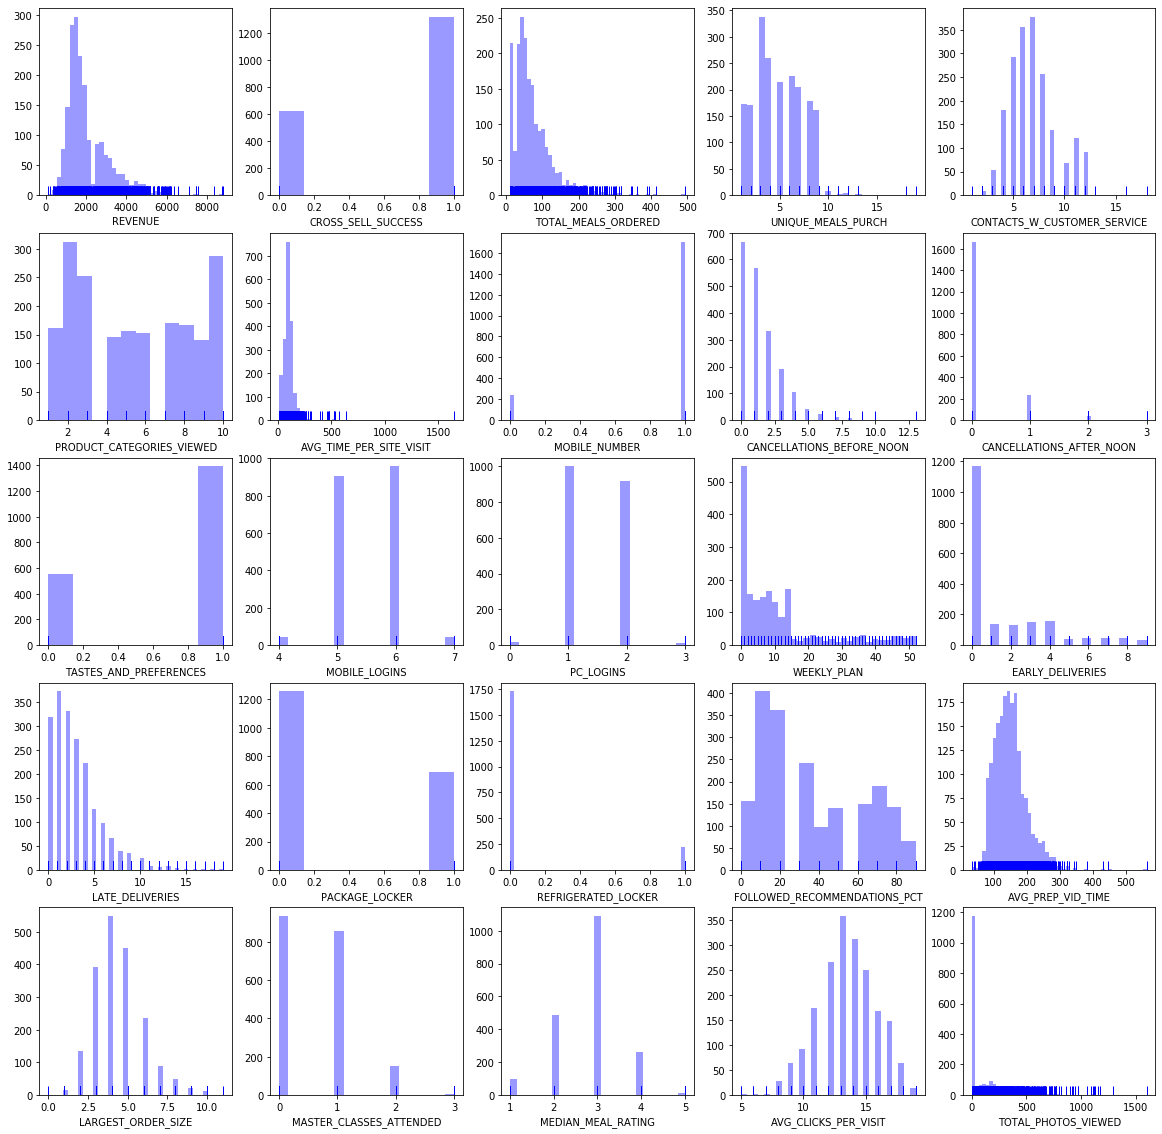

In [3]:
# subset numerical variables 
chef_num = chef.drop(['NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME'], axis=1)

# create a loop to pull histograms to visulaize each numeriable variable 
f, axes = plt.subplots(5, 5, figsize=(20, 20), sharex=False)
for ax, feature in zip(axes.flat, chef_num.columns):
    sns.distplot(chef_num[feature], color="blue", kde=False, rug=True, ax=ax)

From initial visualization of histograms,
<ul>

<li>for some continuous variables such as TOTAL_MEALS_ORDERS, AVG_TIME_PER_SITE_VISIT, TOTAL_PHOTOS_VIEWED are highly skewed to right, check high-end side whether correlate to cross-selling success</li>
<li>for some discrete variables closer to normal distribution such as CONTACT_WITH_CUSTOMERS_SERVICE,LARGEST_ORDER_SIZE, check the outliers both side which might associate to cross-selling promotion</li>
<li>for some discrete variables right skewed such as UNIQUE_MEALS_PURCH, LATER_DELIVERIES, check the outliers high end side which might have relate to cross-selling success</li>
<li>for binary variables such as MOBILE_NUMBER, PACKAGE_LOCKER, keep identity which might high possible connect to cross-selling success</li>
<li>for multimodal such as PRODUCT_CATEGORIES_VIEWED, FOLLOWED_RECOMMENDATIONS_PCT, the effect of different segments to cross-selling wine may vary</li> 
</ul>
<br>

Next step is to set up outliers thresholds to exam logistic correlation

In [4]:
# cross checking quantile interval (0.025 - 0.975)
chef_num.quantile([0.025, 0.975]).round(2)

,REVENUE,CROSS_SELL_SUCCESS,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,MOBILE_LOGINS,PC_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,FOLLOWED_RECOMMENDATIONS_PCT,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED
0.025,790.00,0.0,13.00,1.0,3.0,1.0,29.00,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,79.12,2.0,0.0,1.0,9.0,0.00
0.975,5006.75,1.0,221.75,9.0,12.0,10.0,212.24,1.0,5.0,1.0,1.0,6.0,2.0,49.0,8.0,10.0,1.0,1.0,90.0,264.94,8.0,2.0,4.0,18.0,608.12


In [5]:
# setting outlier thresholds
avg_time_pvisit_hi  = 212.2
avg_prep_vid_time_hi = 264.9
avg_prep_vid_time_lo = 79.1
avg_cli_pvisit_hi  = 18
avg_cli_pvisit_lo  = 9
tot_meals_ord_hi = 221.75
unique_meals_pur_hi = 9
contact_w_CS_hi = 12
contact_w_CS_lo = 3
cancel_b_noon_hi = 5
cancel_a_noon_hi = 1
mobile_log_hi = 6
mobile_log_lo = 5
pc_log_hi = 2
pc_log_lo = 1
weekly_plan_hi = 49
early_d_hi = 8
late_d_hi = 10
tot_photo_v_hi = 608.1
lar_ord_size_hi = 8
lar_ord_size_lo = 2
mas_class_att_hi = 2
med_meal_rat_hi =  4
revenue_hi = 5006.75
revenue_lo = 790

In [6]:
# developing features (columns) for outliers
chef['out_avg_time_pvisit'] = np.where(chef['AVG_TIME_PER_SITE_VISIT']>avg_time_pvisit_hi, 1, 0)
chef['out_avg_prep_video'] = np.where((chef['AVG_PREP_VID_TIME']>avg_prep_vid_time_hi)|(chef['AVG_PREP_VID_TIME']<avg_prep_vid_time_lo), 1, 0 )
chef['out_avg_clicks_pvisit'] = np.where((chef['AVG_CLICKS_PER_VISIT']>avg_cli_pvisit_hi)|(chef['AVG_CLICKS_PER_VISIT']<avg_cli_pvisit_lo), 1, 0 )
chef['out_tot_meals'] = np.where(chef['TOTAL_MEALS_ORDERED']>tot_meals_ord_hi,1, 0 )
chef['out_uni_meals'] = np.where(chef['UNIQUE_MEALS_PURCH']>unique_meals_pur_hi, 1, 0 )
chef['out_contact_CS'] = np.where((chef['CONTACTS_W_CUSTOMER_SERVICE']>contact_w_CS_hi)|(chef['CONTACTS_W_CUSTOMER_SERVICE']<contact_w_CS_lo), 1, 0 )
chef['out_cancel_bnoon'] = np.where(chef['CANCELLATIONS_BEFORE_NOON']>cancel_b_noon_hi, 1, 0 )
chef['out_cancel_anoon'] = np.where(chef['CANCELLATIONS_AFTER_NOON']>cancel_a_noon_hi, 1, 0 )
chef['out_mobile_log'] = np.where((chef['MOBILE_LOGINS']>mobile_log_hi)|(chef['MOBILE_LOGINS']<mobile_log_lo), 1, 0 )
chef['out_pc_log'] = np.where((chef['PC_LOGINS']>pc_log_hi)|(chef['PC_LOGINS']<pc_log_lo), 1, 0 )
chef['out_weekly_plan'] = np.where(chef['WEEKLY_PLAN']>weekly_plan_hi, 1, 0 )
chef['out_early_d'] = np.where(chef['EARLY_DELIVERIES']>early_d_hi, 1, 0 )
chef['out_late_d'] = np.where(chef['LATE_DELIVERIES']>late_d_hi, 1, 0 )
chef['out_tot_photo'] = np.where(chef['TOTAL_PHOTOS_VIEWED']>tot_photo_v_hi, 1, 0 )
chef['out_lar_order'] = np.where((chef['LARGEST_ORDER_SIZE']>lar_ord_size_hi)|(chef['LARGEST_ORDER_SIZE']<lar_ord_size_lo), 1, 0 )
chef['out_master_class'] = np.where(chef['MASTER_CLASSES_ATTENDED']>mas_class_att_hi, 1, 0 )
chef['out_meals_rating'] = np.where(chef['MEDIAN_MEAL_RATING']>med_meal_rat_hi, 1, 0 )
chef['out_revenue'] = np.where((chef['REVENUE']>revenue_hi)|(chef['REVENUE']<revenue_lo), 1, 0 )

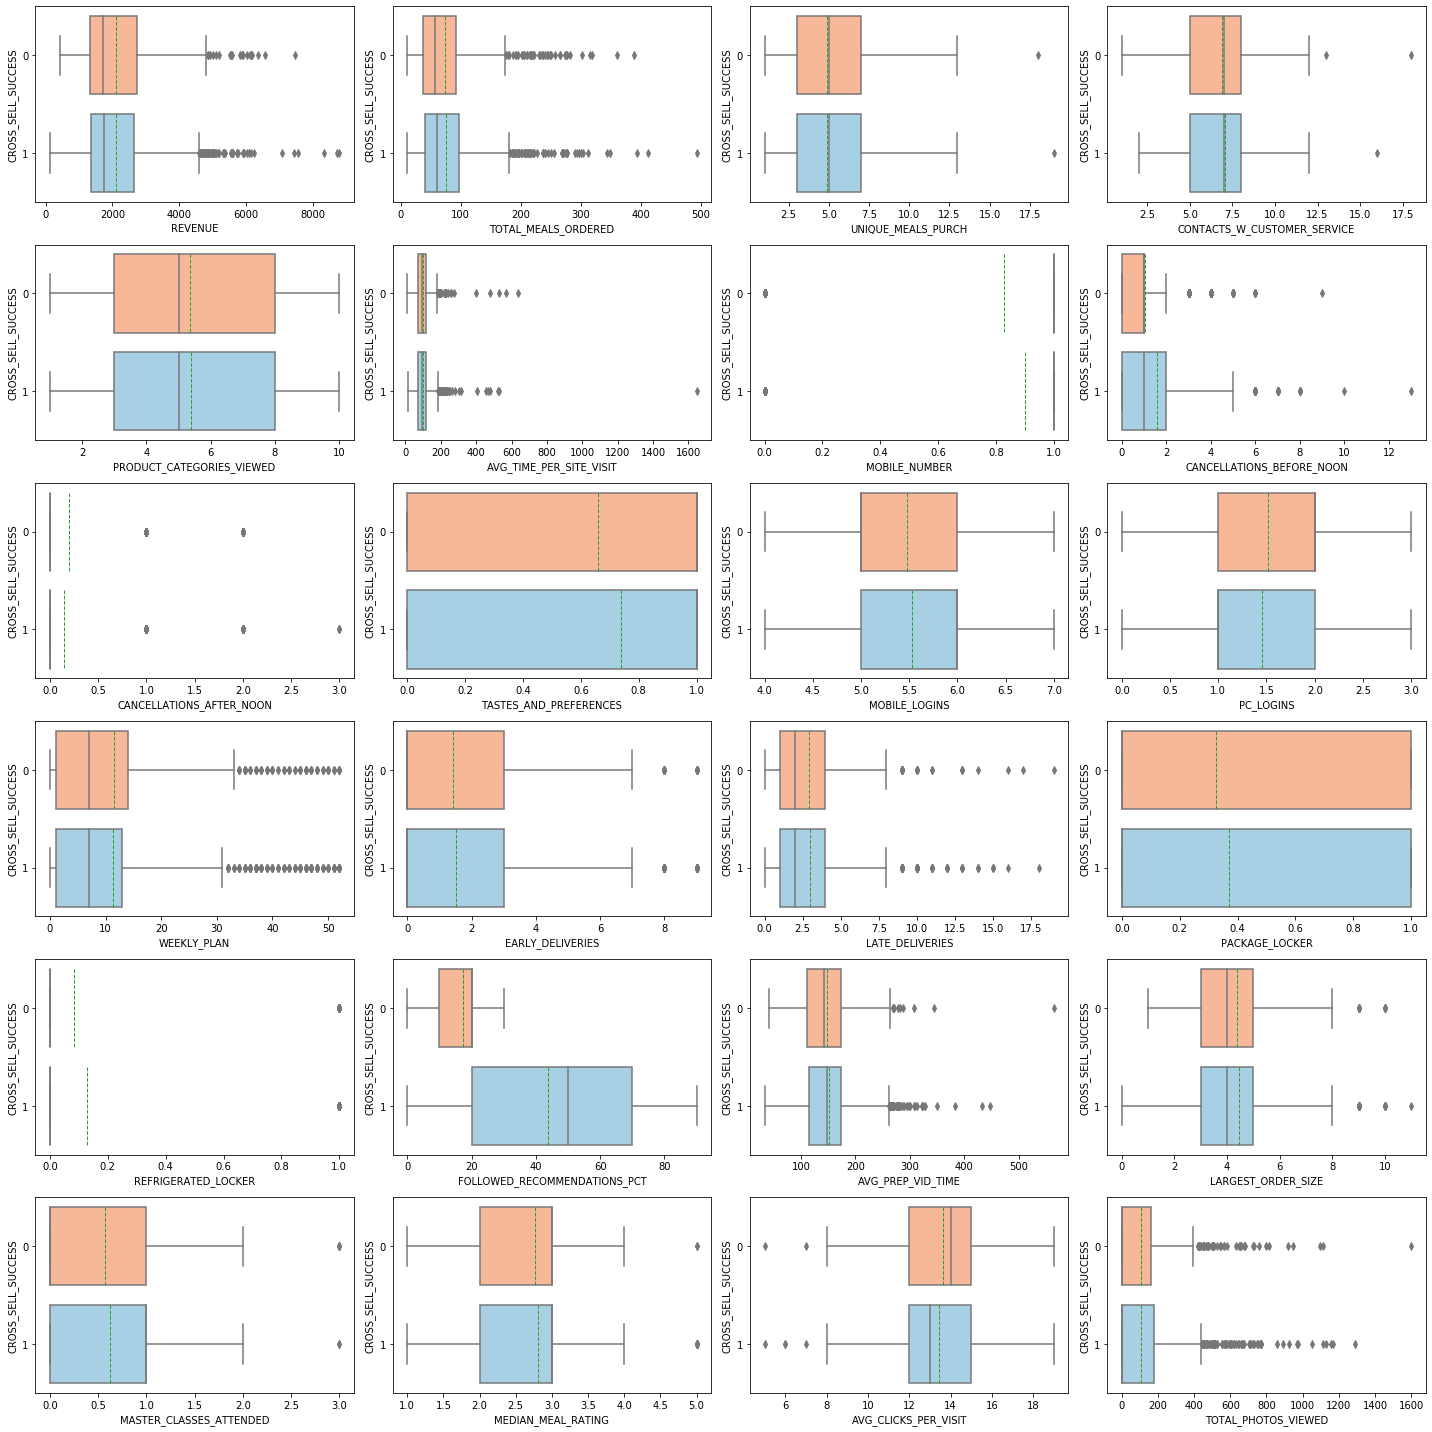

In [7]:
# switch the columns REVENUE and CROSS_SELL_SUCCESS
cols=list(chef_num.columns)
a, b = cols.index('REVENUE'), cols.index('CROSS_SELL_SUCCESS')
cols[a], cols[b] = cols[b], cols[a]
chef_num = chef_num[cols]


# create a loop to pull boxplot to check association between each explortory variables and response variable CROSS_SELL_SUCCESS 
f, axes = plt.subplots(6, 4, figsize=(20, 20), sharex=False, sharey=False)
for ax, col in zip(axes.flat, chef_num.columns[1:]):
    sns.boxplot(data=chef_num,
                 x = chef_num[col],
                 y =chef_num['CROSS_SELL_SUCCESS'],
                 orient= 'h',
                 palette = 'RdBu',
                 saturation=1,
                 meanline=True, 
                 showmeans = True,
                 ax=ax)
    plt.tight_layout()
    

from visualization of boxplots 
<ul>
<li> some variables CANCELLATIONS_BEFORE_NOON, WEEKLY_PLAN, LARGEST_ORDER_SIZE have somewhat different association to cross-selling success; reset the threshold to review</li>
<li> those variables LARGEST_ORDER_SIZE, MASTER_CLASSES_ATTENDED, EARLY_DELIVERIES,TOTAL_PHOTO_VIEWED heavily incline to zero, flagging them to see if any discovery</li>
<li> the variable FOLLOWED_RECOMMENDATIONS_PCT reveals differential to the success or failure of cross-selling, while PRODUCT_CATEGORIES_VIEWED show no sign; both could be segmented and grouped for further exploring </li>
<li> both explanatory variables TOTAL_MEALS_ORDERED and REVENUE look identical to cross-selling binary variable, but may worth to try segment customers to find distinctive information  </li>
<li> most binary variables display vaguely to binary response variable as usual</li>
<li> some variables such as UNIQUE_MEAL_PURCH, CONTACTS_W_CUSTOMER_SERVICE, MOBILE_LOGIN, PC_LOGIN response to cross-selling success or failure is identical, leaving as it</li>
</ul> 
<br>

Based on the observation above, I am going to develop threshold which capture information to improve prediction

In [8]:
# refine thresholds 
cancel_b_noon_change_hi = 1
weekly_plan_change_hi = 30
fol_recomm_pct_change_hi = 20
lar_ord_size_change_lo = 1

cancel_b_noon_zi = 0
early_d_zi = 0
fol_recomm_pct_zi = 0
mas_class_att_zi = 0
tot_photov_zi = 0


In [9]:
# greater than or less than sign

chef['change_cancel_bnoon'] = np.where(chef['CANCELLATIONS_BEFORE_NOON']>cancel_b_noon_change_hi, 1, 0)
chef['change_weekly_plan'] = np.where(chef['WEEKLY_PLAN']>weekly_plan_change_hi, 1, 0)
chef['change_fol_rec_pct'] = np.where(chef['FOLLOWED_RECOMMENDATIONS_PCT']>fol_recomm_pct_change_hi, 1, 0)
chef['change_lar_ord_size'] = np.where(chef['LARGEST_ORDER_SIZE']<=lar_ord_size_change_lo, 1, 0)

# zero inflated
chef['zero_cancel_bnoon'] = np.where(chef['CANCELLATIONS_BEFORE_NOON']==cancel_b_noon_zi, 1, 0)
chef['zero_ear_delivery'] = np.where(chef['EARLY_DELIVERIES']==early_d_zi, 1, 0)
chef['zero_fol_recomm'] = np.where(chef['FOLLOWED_RECOMMENDATIONS_PCT']==fol_recomm_pct_zi, 1, 0)
chef['zero_mas_class_att'] = np.where(chef['MASTER_CLASSES_ATTENDED']==mas_class_att_zi, 1, 0)
chef['zero_tot_view'] = np.where(chef['TOTAL_PHOTOS_VIEWED']==tot_photov_zi, 1, 0)

In [10]:
# separate customers into three groups: 
# 1 - low following recommendation rate; 
# 2 - median following recommendation rate; 
# 3 - high following recommendation rate

placelist = []
for value in chef['FOLLOWED_RECOMMENDATIONS_PCT']:
    if value >=0 and value <30:
        placelist.append('1')
    elif value >=30 and value < 60:
        placelist.append('2')
    elif value >=60 and value <=100:
        placelist.append('3')
    else: 
        print('error')
        
chef['rec_followed_group'] = pd.Series(placelist)


In [11]:
# separate customers into 3 groups: 
# 1 - low product categories viewers;
# 2 - median product categroies viewers; 
# 3 - high product categroies viewers

placelist1 = []
for value in chef['PRODUCT_CATEGORIES_VIEWED']:
    if value >=0 and value < 4:
        placelist1.append('1')
    elif value >=4 and value < 7:
        placelist1.append('2')
    elif value>=7 and value <=10:
        placelist1.append('3')
    else: 
        print('error')
chef['prodcatv_group'] = pd.Series(placelist1)


In [12]:
# convert categorical variables into numerical ones
chef['rec_followed_group'] = pd.to_numeric(chef['rec_followed_group'])
chef['prodcatv_group'] = pd.to_numeric(chef['prodcatv_group'])

In [13]:
# to check if any cross selling pattern among different customers groups 

# segment customers to group 1, 2, 3 & 4 based on revenue contribution (high to low)
chef['m_quartile']= pd.qcut(chef['REVENUE'],4, ['4', '3','2', '1' ])

# segment customers to group 1, 2, 3, & 4 based on order frequency (high to low)
chef['f_quartile']= pd.qcut(chef['TOTAL_MEALS_ORDERED'],4, ['4', '3','2', '1' ])

In [14]:
# convert categorical variables into numerical ones
chef['m_quartile'] = pd.to_numeric(chef['m_quartile'])
chef['f_quartile'] = pd.to_numeric(chef['f_quartile'])

 <h5> Categorical Variables </h5>
 <br>
 
 Since marketing team claimed customers' email domain somewhat related to response rate, I'd like to examine whether three e-mail domain groups (professional, personal, junk) have anything to do with cross-selling success

In [15]:
# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chef.iterrows():
    
    # splitting email domain at '@'
    split_email = chef.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)


# displaying the results
email_df

,0,1
0,addam.osgrey,passport.com
1,aegon.blackfyre,jnj.com
2,aegon.frey.(son.of.aenys),gmail.com
3,aegon.targaryen.(son.of.rhaegar),ibm.com
4,aegon.v.targaryen,goldmansacs.com
...,...,...
1941,yandry,yahoo.com
1942,yorkel,gmail.com
1943,young.henly,gmail.com
1944,ysilla,protonmail.com


In [16]:
# renaming column to concatenate
email_df.columns= ['id', 'email_domain']


# concatenating personal_email_domain with friends DataFrame
chef = pd.concat([chef, email_df.loc[:, 'email_domain']],axis =1)


In [17]:
# email domain types
professional_email_domains = [ '@jnj.com',  '@ibm.com',
       '@goldmansacs.com', '@homedepot.com','@caterpillar.com',
         '@verizon.com', '@merck.com', '@unitedtech.com', '@nike.com',
       '@unitedhealth.com', '@mcdonalds.com', '@pg.com', '@mmm.com',
       '@apple.com', '@cisco.com', '@travelers.com', '@cocacola.com',
       '@jpmorgan.com', '@chevron.com', '@amex.com', '@dupont.com',
       '@boeing.com', '@exxon.com', '@intel.com', '@ge.org', '@disney.com',
       '@microsoft.com', '@pfizer.com', '@visa.com', '@walmart.com']
personal_email_domains  = ['@gmail.com', '@yahoo.com', '@protonmail.com']
junk_email_domains = ['@me.com', '@aol.com', '@hotmail.com', '@live.com', '@msn.com','@passport.com']

# placeholder list
placeholder_lst2 = []


# looping to group observations by domain type
for domain in chef['email_domain']:
        if '@' + domain in professional_email_domains:
            placeholder_lst2.append('professional')
            
        elif '@' + domain in personal_email_domains:
            placeholder_lst2.append('personal')
            
        elif '@' + domain in junk_email_domains:
            placeholder_lst2.append('junk')
                        
        else:
            print('Unknown')


# concatenating with original DataFrame
chef['domain_group'] = pd.Series(placeholder_lst2)


# checking results
chef['domain_group'].value_counts()

personal        861
professional    696
junk            389
Name: domain_group, dtype: int64

Another thought is that female and male might have distinctive react to cross-selling offer. Since gender is not available  in current dataset, I speculate according to given name of customers  

In [18]:
# guess gender based on (given) name

d = gender.Detector()

chef['gender'] = chef['FIRST_NAME'].map(lambda x: d.get_gender(x))

In [19]:
chef['gender'].value_counts()

unknown          1385
male              381
female            125
mostly_male        24
mostly_female      21
andy               10
Name: gender, dtype: int64

In [20]:
# mapping gender to dataframe

chef['gender'] = chef['gender'].map({
      'mostly_female': 'female', 
      'mostly_male': 'male', 
      'andy': 'male',
      'female' : 'female',
      'male' : 'male',
      'unknown': 'unknown'
})

In [21]:
# make a list of unknow gender
chef_u = list(chef['FIRST_NAME'][chef['gender'] == 'unknown'])


# working on gender infered from first name
male_list = ['Addam','Aegon','Aegor','Aelinor','Aemon','Aggar','Aggo','Alannys',
             'Albett','Alebelly','Arson','Artos','Arwyn','Baelor','Barbrey',
             'Barre','Barristan','Barth','Beck','Beldecar','Bellegere','Beron',
             'Black','Bloodbeard','Bodger','Bonifer','Boros','Bradamar','Brogg',
             'Bronn','Byan','Calon','Canker','Carellen','Cetheres','Chett',
             'Chiswyck','Cleos','Coldhands','Colemon','Corlys','Cortnay',
             'Crawn','Cuger','Dacks','Daemon','Daeron','Dafyn','Dagon','Dake',
             'Danwell','Dickon','Donel','Donnel','Donnor','Dontos','Dornish',
             'Draqaz','Drennan','Duram','Eddard','Edderion','Edmyn','Edric',
             'Edwyn','Eggon','Endrew','Fornio','Fralegg','Frenken','Garizon',
             'Garlan','Garse','Gendel','Gorold','Gran','Grazdan','Grazdar',
             'Greydon','Gulian','Guthor','Gwayne','Gyles','Halmon','Harle',
             'Harren','Harrold','Harwyn','Hoarfrost','Hoke','Hot','Hother',
             'Humfrey','Hunnimore','Irri','Jack-Be-Lucky','Jaremy','Jeor',
             'Jhaqo','Jhiqui','Aerion','Andros','Androw','Arys','Bael','Balman',
             'Balon','Bannen','Belwas','Benjen','Beric','Boremund','Borroq',
             'Bran','Branston','Brown','Brynden','Byam','Byren','Cleyton','Cohollo',
             'Collio','Colmar','Cossomo','Craghas','Cragorn','Cregan','Cutjack',
             'Dagmer','Jonos','Deziel','Doran','Dunaver','Dunsen','Durran','Easy',
             'Edmure','Edwyd','Elys','Eon','Erryk','Esgred','Falyse','Farlen',
             'Ferrego','Flement','Garigus','Godwyn','Gormond','Gurn','Guyard',
             'Gwin','Gylbert','Gynir','Hake','Halder','Haldon','Horas','Halys',
             'Harlon','Harmond','Harmune','Harrag','Harwin','Harwood','Harys',
             'Hayhead','Hazrak','Helliweg','High','Hizdahr','Hobb','Hoster',
             'Howland','Hullen','Hyle','Ilyn','Jaehaerys','Jate','Aemond',
             'Alekyne','All-for-Joffrey','Allaquo','Ambrode','Andar','Antario',
             'Arrec','Arwood','Axell','Azor','Azzak','Baelon','Barthogan','Bayard',
             'Bearded','Benedar','Bennis','Beqqo','Betharios','Bharbo','Big',
             'Blind','Blue','Bluetooth','Briar','Brusco','Bryen','Butterbumps',
             'Cellador','Clubfoot','Clydas','Colen','Coratt','Cotter','Daegon',
             'Dagos','Dancy','Danos','Delonne','Delp','Domeric','Dykk','Ebrose',
             'Eddison','Edrick','Eldiss','Emphyria','Erreck','Erreg','Fogo',
             'Galazza','Galladon','Galyeon','Gawen','Gelmarr','Gendry','Gerardys',
             'Gerren','Gerris','Gevin','Gillam','Gilwood','Gladden','Godric',
             'Godry','Gormon','Gowen','Great','Green','Greenbeard','Grey','Grubbs',
             'Gunthor','Guyne','Gwynesse','Gyleno','Gyloro','Daario','Hallis',
             'Hareth','Harmund','Heward','Horton','Husband','Imry','Jafer',
             'Jeffory','Walys','Jhogo','Jorelle','Joseth','Jyck','Kaeth',
             'Kennos','Kirth','Kojja','Kurz','Lamprey','Lancel','Larence','Leathers',
             'Lem','Lenn','Lewys','Lister','Lomys','Lorent','Lotho','Lucimore',
             'Lucion','Lucos','Lymond','Mace','Mallor','Malwyn','Manfrey','Manfryd',
             'Mathos','Mawney','Medgar','Melwys','Mollos','Moreo','Moryn','Mudge',
             'Murch','Naerys','Narbert','Norjen','Normund','Tybolt','Rodrik',
             'Ollidor','Olyvar','Jonothor','Joth','Karyl','Kedge','Koss','Kraznys',
             'Kromm','Kurleket','Kyleg','Lark','Lenwood','Lenyl','Leobald','Leonette',
             'Loras','Lorcas','Gallard','Lord','Lorren','Luwin','Lythene',
             'Marwyn','Matrice','Mazdhan','Mebble','Meldred','Melly','Merrell',
             'Mezzara','Monterys','Moonshadow','Mord','Morgarth','Morros','Munciter',
             'Mychel','Mallador','Walder','Old','Ollo','Olymer','Jorah','Joyeuse',
             'Ardrian','Kemmett','Kezmya','Khorane','Khrazz','Larys','Lennocks',
             'Lomas','Lothor','Lucamore','Lucifer','Luco','Luthor','Lync','Lysono',
             'Maelor','Mance','Marillion','Marq','Medger','Melicent','Aglantine',
             'Melwyn','Merlon','Merrett','Mikken','Miklaz','Moredo','Moribald',
             'Mullin','Murenmure','Muttering','Mycah','Narbo','Notch','Nymeria',
             'Nymos','Ondrew','Orell','Ormund','Orphan','Orwyle','Orys','Otter',
             'Ottomore','Ottyn','Pate','Patrek','Paxter','Pearse','Plummer',
             'Podrick','Pyat','Pylos','Qarl','Quenton','Quort','Ermesande',
             'Randyll','Rawney','Reznak','Rhaegar','Rhaegel','Rhaego','Rhaella',
             'Roelle','Rolder','Rolfe','Ronnel','Roose','Rugen','Ryam','Rycherd',
             'Ryman','Salladhor','Sallor','Salloreon','Samwell','Sargon','Senelle',
             'Shagga','Shyra','Sour','Squint','Stevron','Stonehand','Sylas',
             'Symond','Syrio','Tarber','Theon','Thormor','Timeon','Timett',
             'Todric','Tommard','TomToo','Torbert','Torrhen','Tregar','Tristifer',
             'Tumberjon','Tya','Tybero','Tyene','Tyland','Tyrek','Tyrion','Tywin',
             'Ulwyck','Vaemond','Valarr','Viserys','Vortimer','Waldon','Wallen',
             'Warryn','Willam','Willum','Wyl','Yellow','Ygon','Oro','Orton',
             'Osbert','Osfryd','Pono','Porridge','Porther','Portifer','Prendahl',
             'Qarlton','Qarro','Quellon','Quhuru','Quickfinger','Rafe','Edgerran',
             'Raymar','Raymun','Redwyn','Regenard','Reysen','Rickon',
             'Robar','Robett','Rolly','Roone','Rylene','Saathos','Sedgekins',
             'Sigrin','Skinner','Styr','Tallad','Tansy','Tanton','Three','Timoth',
             'Tion','Tobbot','Tommen','Tremond','Trystane','Ulrick','Umfred',
             'Urrathon','Urswyck','Urzen','Utherydes','Uthor','Vardis','Vargo',
             'Varly','Vickon','Wayn','Weese','Werlag','Willamen','Willas','Wolmer',
             'Woth','Wynafryd','Xhondo','Orbelo','Osney','Oswell','Oswyn',
             'Othell','Oznak','Parmen','Perriane','Petyr','Praed','Quill','Ragnor',
             'Helman','Maegor','Rat','Reynard','Rhaelle','Romny','Roryn','Runcel',
             'Ryles','Ryon','Sandor','Sarra','Sebaston','Sigfry','Skahaz','Skyte',
             'Spare','Spotted','Stalwart','Steely','Stonesnake','Sybassion',
             'Sybell','Ternesio','Theodan','Theomar','Thoren','Toregg','Trebor',
             'Tumco','Tysane','Tyta','Tytos','Uller','Urreg','Varamyr','Vayon',
             'Shortear','Waltyr','Wat','Whalen','Willifer','Toefinger','Wun',
             'Wylis','Wynafrei','Wynton','Yohn','Yormwell','Zei','Zekko','Zharaq',
             'Zhoe','Abelar','Aethelmure','Alequo','Laenor','Denyo','Alfyn','Anguy',
             'Arneld','Arnell','Arryk','Arthor','Ayrmidon','Ballabar','Bandy',
             'Beardless','Bedwyck','Benfred','Bennard','Bennarion','Biter','Bors',
             'Bump','Buu','Cadwyn','Castos','Cedrik','Cerrick','Cheyk','Chiggen',
             'Clarent','Craster','Cressen','Criston','Dalbridge','Dareon','Squinty',
             'Dhazzar','Dormund','Drogo','Dryn','Dywen','Edwyle','Elder','Elron',
             'Emmon','Emmond','Emrick','Eroeh','Eyron','Ezzelyno','Jothos','Urron',
             'Alyx','Ferret','Galtry','Gascoyne','Ghael','Grenn','Gretchel',
             'Groleo','Gueren','Guncer','Gyldayn','Haggon','Hairy','Harghaz',
              'Harra','Harras','Harrion','Harsley','Hazzea','Helicent','Henly',
             'Hodor','Hop-Robin','Hosman','Hosteen','Hotho','Hubard','Hugor',
             'Illyrio','Ironbelly','Jacks','Jaggot','Jammos','Janos','Jeren',
             'Jodge','Jojen','Jyzene','Kedry','Kenned','Larraq','Left','Lewyn',
             'Lharys','Lucan','Lum','Mad','Maege','Malliard','Mandon','Matarys',
             'Matthar','Matthos','Meizo','Merrit','Monster','Moro','Morrec',
             'Murmison','Nage','Nettles','Nissa','Norne','Norren','Nute','Ocley',
             'Ogo','Orbert','Orivel','Ossifer','Ossy','Othor','Palla','Perwyn',
             'Poetess','Pollitor','Polliver','Poxy','Puckens','Pudding',
             'Puddingfoot','Pycelle','Pyg','Pypar','Qotho','Quaro','Qyburn',
             'Racallio','Ragwyle','Rakharo','Redtusk','Reek','Renfred','Renly',
             'Rhogoro','Ricasso','Rodwell','Roggo','Rollam','Ronel','Ronnet',
             'Rorge','Roro','Rossart','Rudge','Runciter','Ryger','Rymolf',"Sailor's",
             'Sawwood','Scarb','Selmond','Shae','Sherrit','Sigfryd','Skittrick',
             'Squirrel','Stannis','Yoren','Xaro','Endehar','Mushroom','Frenya',
             'Albar','Satin','Errok','Enger','Galbart','Likely','Todder','Haggo',
             'Goady','Grigg','Joramun','Wendello','Forley','Medwick','Steelskin',
             'Stiv','Stygg','Tanselle','Terro','Theomore','Thistle','Hobber',
             'Illifer','Mollander','Lollys','Shagwell','Gared','Karlon','Daven',
             'Rigney','Togg','Tomard','Tormund','Torrek','Torren','Torwynd',
             'Ryk','Malleon','Jorgen','Zollo','Ghost','Frynne','Gorne','Tristimun',
             'Tuffleberry','Turnip','Patchface','Goodwin','Osmynd','Umma','Gerion',
             'Mago','Mero','Watt','Tymor','Chayle','Davos','Bhakaz','Carrot',
             'Tysha','Ulmer','Unella','Urek','Vyman','Tothmure','Turquin','Rast',
             'Jalabhar','Benfrey','Urrigon','Qos','Tygett','Ordello','Qhorin',
             'Mully','Tagganaro','Varys','Mohor','Veiled','Victarion','Vylarr',
             'Wex','Luton','Cadwyl','Utt','Cley','Maric','Perros','Walgrave',
             'Moqorro','Borcas','Jonnel','Harodon','Mirri','Jommy','Kegs','Grisel',
             'Jommo','Monford','Wate','Watty','Luceon','Osha','Sloey','Meribald',
             'Argrave','Lucias','Rafford','Weasel','Tobho','Dyah','Dunstan',
             'Wulfe','Cosgrove','Three-Tooth','Conwy','Hibald','Grunt','Areo',
             'Rhae','Willit','Yandry','Mors','Yorkel']
 
female_list = ['Aemma','Alester','Alicent','Alysanne','Annara','Bass','Berena',
               'Bessa','Brenett','Caleotte','Cyrenna', 'Daella','Daughter','Delena',
               'Doreah','Ebben','Eustace','Falia','Janei','Jaqen','Jeyne','Aladale',
               'Ashara','Belandra','Cassella','Catelyn','Cerenna','Chella',
               'Daena','Daenerys','Yorko','Dorea','Eddara','Elaena','Eleyna',
               'Ellaria','Elyn','Erena','Gariss','Grance','Grisella','Gysella',
               'Helya','Aenys','Aethan','Alliser','Allyria','Baela','Cynthea',
               'Dacey','Donyse','Falena','Jacelyn','Jaehaera','Jyana','Ketter',
               'Lann','Lanna','Lyessa','Maerie','Marghaz','Maslyn','Melara',
               'Mellara','Missandei','Obella','Oberyn','Olene','Jynessa','Laena',
               'Lyanna','Mag','Margaery','Megga','Melesa','Merling','Moelle',
               'Mother','Mysaria','Noho','Nymella','Olenna','Jyanna','Kella',
               'Layna','Loreza','Lucantine','Lynesse','Marsella','Meha','Melessa',
               'Meliana','Bellonara','Meryn','Minisa','Nightingale','Quentyn',
               'Sansa','Sawane','Selyse','Steffon','Sybelle','Valaena','Quenten',
               'Ravella','Sarella','Sarya','Scolera','Sefton','Serala','Serwyn',
               'Steffarion','Talla','Tyana','Qalen','Perra','Qyle','Rennifer',
               'Rhialta','Rosey',"S'vrone",'Saera','Sallei','Shiera','Shierle',
               'Small','Smiling','Sumner','Sylwa','Tanda','Tarle','Wylla',
               'Vaellyn','Visenya','Waymar','Wendamyr','Softfoot','Ygritte','Yna',
               'Zarabelo','Alerie','Agrivane','Carolei','Morra','Alvyn','Alysane',
               'Amarei','Amerei','Arya','Belis','Brea','Brella','Cassana','Cayn',
               'Cedra','Cersei','Chataya','Daeryssa','Darlessa','Daryn','Denestan',
               'Dobber','Donnis','Elyana','Emberlei','Erren','Mellos','Hallyne',
               'Helaena','Jorquen','Joseran','Josmyn','Jurne','Lady','Leslyn',
               'Maegelle','Mela','Melaquin','Meralyn','Merianne','Mordane','Morya',
               'Mylenda','Myrcella','Nolla','Nysterica','Obara','Quaithe','Quent',
               'Rainbow','Rhaena','Rohanne','Ryella','Sharna','Shirei','Myria',
               'Taena','Mellei','Melisandre','Alayaya','Bellena','Victaria',
               'Quence','Larra','Ezzara','Aerys','Rhaenys','Ysilla']
print(len(male_list))
print(len(female_list))



        
placeholder3 = []

for name in chef_u:
        if name in male_list:
            placeholder3.append('male')
        elif name in female_list:
            placeholder3.append('female')
            
        else:
             print('error')
#create dataframe with first name and gender            
chef_unknown = pd.DataFrame({
    'FIRST_NAME': chef_u,
    'gender': placeholder3
})
chef_unknown

905
208


,FIRST_NAME,gender
0,Addam,male
1,Aegon,male
2,Aegon,male
3,Aegon,male
4,Aegon,male
...,...,...
1380,Willit,male
1381,Yandry,male
1382,Yorkel,male
1383,Ysilla,female


In [22]:
#map chef_unknown back to dataframe chef
m = chef['gender'].eq('unknown')
chef['gender'] = chef['FIRST_NAME'].map(chef_unknown.drop_duplicates().set_index('FIRST_NAME')['gender']).where(m,chef['gender'])

In [23]:
chef['gender'].value_counts()

male      1538
female     408
Name: gender, dtype: int64

In [24]:
# one hot encoding categorical variables
one_hot_domain       = pd.get_dummies(chef['domain_group'])
one_hot_gender       = pd.get_dummies(chef['gender'])


# dropping categorical variables after they've been encoded
chef = chef.drop('domain_group', axis = 1)
chef = chef.drop('gender', axis = 1)

# joining codings together
chef = chef.join([one_hot_domain, one_hot_gender])

In [25]:
# saving results
chef.to_excel('chef_feature_rich_A2.xlsx',
                 index = False)
chef=pd.read_excel('chef_feature_rich_A2.xlsx')

<h4><b> Initiate Logistic Regression Full Modeling </h4><b>

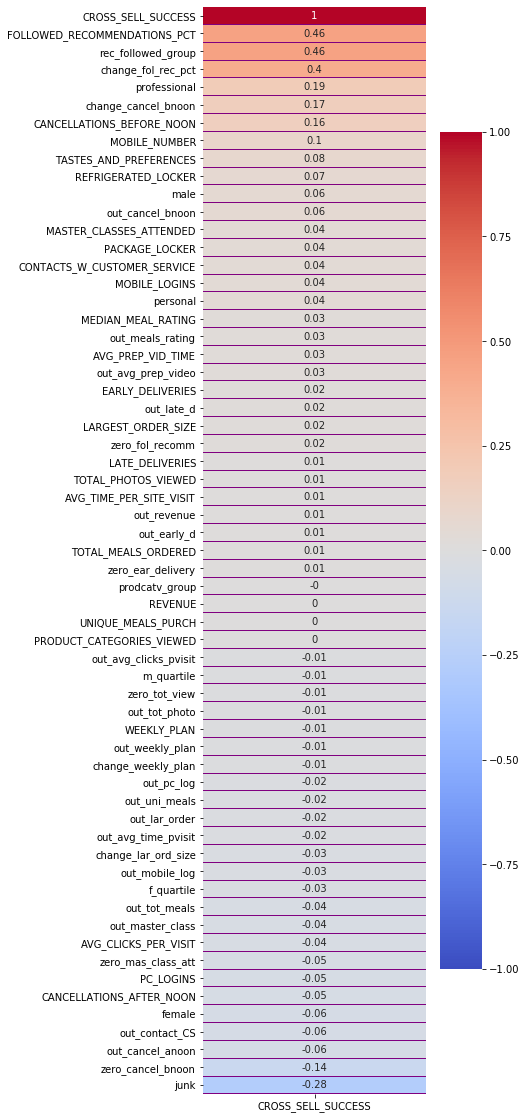

In [26]:
# creating a (Pearson) correlation matrix
chef_corr = chef.corr().round(2)

plt.figure(figsize=(5,20))

# printing (Pearson) correlations with CROSS_SELLING_SUCCESS
sns.heatmap(chef_corr[['CROSS_SELL_SUCCESS']].sort_values(by=['CROSS_SELL_SUCCESS'],ascending=False),
            cmap='coolwarm', vmin=-1, vmax=1,linecolor='purple',linewidths=0.01,
            annot=True)

In [27]:
# declaring explanatory variables
chef_data = chef.drop(['CROSS_SELL_SUCCESS','NAME','EMAIL','FIRST_NAME', 'FAMILY_NAME','email_domain'], axis = 1)


# declaring response variable
chef_target =chef.loc[ : , 'CROSS_SELL_SUCCESS']

In [28]:
# train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            chef_data,
            chef_target,
            test_size = 0.25,
            random_state = 222,
            stratify = chef_target)


# merging training data for statsmodels
chef_train = pd.concat([X_train, y_train], axis = 1)

In [29]:
# instantiating a logistic regression model object for full models
logistic_full = smf.logit(formula =  "CROSS_SELL_SUCCESS ~ \
                                        REVENUE +\
                                        TOTAL_MEALS_ORDERED +\
                                        UNIQUE_MEALS_PURCH +\
                                        CONTACTS_W_CUSTOMER_SERVICE +\
                                        PRODUCT_CATEGORIES_VIEWED +\
                                        AVG_TIME_PER_SITE_VISIT +\
                                        MOBILE_NUMBER +\
                                        CANCELLATIONS_BEFORE_NOON +\
                                        CANCELLATIONS_AFTER_NOON +\
                                        TASTES_AND_PREFERENCES +\
                                        MOBILE_LOGINS +\
                                        PC_LOGINS +\
                                        WEEKLY_PLAN +\
                                        EARLY_DELIVERIES +\
                                        LATE_DELIVERIES +\
                                        PACKAGE_LOCKER +\
                                        REFRIGERATED_LOCKER +\
                                        FOLLOWED_RECOMMENDATIONS_PCT +\
                                        AVG_PREP_VID_TIME +\
                                        LARGEST_ORDER_SIZE +\
                                        MASTER_CLASSES_ATTENDED +\
                                        MEDIAN_MEAL_RATING +\
                                        AVG_CLICKS_PER_VISIT +\
                                        TOTAL_PHOTOS_VIEWED +\
                                        out_avg_time_pvisit +\
                                        out_avg_prep_video +\
                                        out_avg_clicks_pvisit +\
                                        out_tot_meals +\
                                        out_uni_meals +\
                                        out_contact_CS +\
                                        out_cancel_bnoon +\
                                        out_cancel_anoon +\
                                        out_mobile_log +\
                                        out_pc_log +\
                                        out_weekly_plan +\
                                        out_early_d +\
                                        out_late_d +\
                                        out_tot_photo +\
                                        out_lar_order +\
                                        out_master_class +\
                                        out_meals_rating +\
                                        out_revenue +\
                                        change_cancel_bnoon +\
                                        change_weekly_plan +\
                                        change_fol_rec_pct +\
                                        change_lar_ord_size +\
                                        zero_cancel_bnoon +\
                                        zero_ear_delivery +\
                                        zero_fol_recomm +\
                                        zero_mas_class_att +\
                                        zero_tot_view +\
                                        rec_followed_group +\
                                        prodcatv_group +\
                                        m_quartile +\
                                        f_quartile +\
                                        junk +\
                                        professional +\
                                        male",                                                                               
                                        data    = chef_train)


# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary()

         Current function value: 0.378968
         Iterations: 35


C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1400
Method:                           MLE   Df Model:                           58
Date:                Wed, 08 Apr 2020   Pseudo R-squ.:                  0.3965
Time:                        11:48:09   Log-Likelihood:                -552.91
converged:                      False   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                2.932e-116
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      -23.3211   1.23e+04     -0.002      0.998   -2.42e+04    2.41e+04
REVENUE                         -0.0002      0.000     -1.292      0.196      -0.001       0.000
TOTAL_MEALS_ORDERED             -0.0010      0.004     -0.274      0.784      -0.008       0.006
UNIQUE_MEALS_PURCH               0.0024      0.033      0.073      0.942      -0.063       0.067
CONTACTS_W_CUSTOMER_SERVICE      0.0280      0.037      0.756      0.450      -0.045       0.101
PRODUCT_CATEGORIES_VIEWED        0.0063      0.077      0.081      0.935      -0.144       0.157
AVG_TIME_PER_SITE_VISIT          0.0031      0.002      1.531      0.126      -0.001       0.007
MOBILE_NUMBER                    0.8498      0.221      3.839      0.000       0.416       1.284
CANCELLATIONS_BEFORE_NOON       -0.0393      0.132     -0.297      0.766      -0.299       0.220
CANCELLATIONS_AFTER_NOON        -0.1844      0.227     -0.811      0.417      -0.630       0.261
TASTES_AND_PREFERENCES           0.2463      0.165      1.494      0.135      -0.077       0.569
MOBILE_LOGINS                    0.2210      0.129      1.711      0.087      -0.032       0.474
PC_LOGINS                       -0.3432      0.142     -2.411      0.016      -0.622      -0.064
WEEKLY_PLAN                      0.0068      0.011      0.601      0.548      -0.015       0.029
EARLY_DELIVERIES                 0.1392      0.061      2.282      0.022       0.020       0.259
LATE_DELIVERIES                  0.0369      0.032      1.164      0.245      -0.025       0.099
PACKAGE_LOCKER                  -0.1560      0.178     -0.878      0.380      -0.504       0.192
REFRIGERATED_LOCKER              0.3540      0.283      1.249      0.212      -0.201       0.909
FOLLOWED_RECOMMENDATIONS_PCT     0.1105      0.014      7.996      0.000       0.083       0.138
AVG_PREP_VID_TIME                0.0023      0.004      0.654      0.513      -0.005       0.009
LARGEST_ORDER_SIZE              -0.0331      0.089     -0.370      0.712      -0.208       0.142
MASTER_CLASSES_ATTENDED          0.2733      0.321      0.851      0.395      -0.356       0.903
MEDIAN_MEAL_RATING              -0.1658      0.214     -0.775      0.439      -0.585       0.254
AVG_CLICKS_PER_VISIT            -0.0804      0.064     -1.261      0.207      -0.205       0.045
TOTAL_PHOTOS_VIEWED              0.0009      0.001      0.996      0.319      -0.001       0.003
out_avg_time_pvisit             -0.5758      0.629     -0.915      0.360      -1.809       0.657
out_avg_prep_video               0.1213      0.422      0.287      0.774      -0.707       0.949
out_avg_clicks_pvisit           -0.5606      0.549     -1.022      0.307      -1.636       0.515
out_tot_meals                   -0.4795      0.719     -0.667      0.505      -1.889       0.930
out_uni_meals                    0.0747      0.790      0.095      0.925      -1.473       1.623
out_contact_CS                  -1.1430 

I need to identify significant variables according to P-Value to creative more informative logistic regression model

In [30]:
# instantiating a logistic regression model object for signifcant variables
logit_sig = smf.logit(formula = " CROSS_SELL_SUCCESS ~ \
                                        MOBILE_NUMBER +\
                                        PC_LOGINS +\
                                        FOLLOWED_RECOMMENDATIONS_PCT +\
                                        out_tot_photo +\
                                        change_cancel_bnoon +\
                                        zero_fol_recomm +\
                                        rec_followed_group +\
                                        f_quartile +\
                                        junk +\
                                        professional +\
                                        male ",
                                        data  = chef_train)


# fitting the model object
logit_sig = logit_sig.fit()

# checking the results SUMMARY
logit_sig.summary()

Optimization terminated successfully.
         Current function value: 0.403714
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1447
Method:                           MLE   Df Model:                           11
Date:                Wed, 08 Apr 2020   Pseudo R-squ.:                  0.3571
Time:                        11:48:09   Log-Likelihood:                -589.02
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                3.261e-133
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.2167      0.424     -2.867      0.004      -2.049      -0.385
MOBILE_NUMBER                    0.8150      0.213      3.828      0.000       0.398       1.232
PC_LOGINS                       -0.2717      0.135     -2.009      0.045      -0.537      -0.007
FOLLOWED_RECOMMENDATIONS_PCT     0.1261      0.013      9.674      0.000       0.101       0.152
out_tot_photo                   -1.0214      0.493     -2.072      0.038      -1.988      -0.055
change_cancel_bnoon              0.8786      0.157      5.610      0.000       0.572       1.186
zero_fol_recomm                  2.7046      0.300      9.024      0.000       2.117       3.292
rec_followed_group              -1.3140      0.307     -4.282      0.000      -1.915      -0.713
f_quartile                      -0.1722      0.066     -2.611      0.009      -0.301      -0.043
junk                            -1.1921      0.187     -6.381      0.000      -1.558      -0.826
professional                     0.7117      0.168      4.233      0.000       0.382       1.041
male                             0.3855      0.174      2.210      0.027       0.044       0.727
================================================================================================
"""

<h4><b>Final Modeling Building </h4><b>
<h5> Import Package and Load Dataset</h5>

In [31]:
# Preparing classification modeling

# loading data
chef = pd.read_excel('chef_feature_rich_A2.xlsx')

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)


<h5> Split Train and Test Sets</h5>

In [32]:

# prepare significant variables data
chef_data   =  chef.loc[ : , [ 'MOBILE_NUMBER','PC_LOGINS', 
                                 'FOLLOWED_RECOMMENDATIONS_PCT',
                                 'change_cancel_bnoon','zero_fol_recomm' ,
                                 'rec_followed_group','f_quartile',
                                  'junk','professional','male']]
# prepare target variable data
chef_target =  chef.loc[ : , 'CROSS_SELL_SUCCESS']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            chef_data,
            chef_target,
            test_size    = 0.25,
            random_state = 222,
            stratify     = chef_target)


<h5> Testing Several Scikit-learn Classification Modelings to Determine Final Optimal Model</h5>

I have been trying several classification models as well as tuning hyperparameters to get better prediction. 
<ul>
<li>I used Grid Search cross-validation to locate best estimators for logistic regression, Random Forest and Gradient Boosting model, then input optimal set of hyperparameters when instantiating models. Only show one example for Logistic Regression model here in the interest of time.</li>
<li>I also did KNN classification after scaling up, but omit here because the result is not so much better in this particular case </li>

In [33]:
########################################
# GridSearchCV
########################################

# declaring a hyperparameter space
C_space          = np.arange(0.1, 3.5, 0.1)
warm_start_space = [True, False]


# creating a hyperparameter grid
param_grid = {'C'          : C_space,
              'warm_start' : warm_start_space}


# INSTANTIATING the model object 
lr_tuned = LogisticRegression(solver = 'lbfgs',
                              random_state = 222)


# GridSearchCV object
lr_tuned_cv = GridSearchCV(estimator  = lr_tuned,
                           param_grid = param_grid,
                           cv         = 3,
                           scoring    = make_scorer(roc_auc_score,
                                                    needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
lr_tuned_cv.fit(chef_data, chef_target)

lr_tuned_cv.best_estimator_

C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LogisticRegression(C=2.7, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=222, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True)

In [34]:
# create loop to get scores for multi-models including some tuned hyperparameters
names=[]
train_scores =[]
test_scores =[]
AUC_scores = []

models={'Logistic Regression': LogisticRegression(),
        'Tuned LR': LogisticRegression(solver = 'lbfgs', C = 2.7, warm_start= True, random_state = 222),
        'Decision Tree': DecisionTreeClassifier(),
        'Pruned Tree': DecisionTreeClassifier(max_depth = 4,min_samples_leaf = 25,random_state = 222),
        'Tuned Tree': DecisionTreeClassifier(criterion='gini', splitter = 'random', max_depth = 5, min_samples_leaf = 79, random_state = 222),
        'Random Forest': RandomForestClassifier(n_estimators = 10, criterion = 'gini', max_depth = None, min_samples_leaf = 1,
                                bootstrap = True, warm_start = False, random_state = 222),
        'Tuned Random Forest': RandomForestClassifier(bootstrap = True, criterion = 'gini', min_samples_leaf = 11,
                                n_estimators = 850, warm_start = True, random_state = 222),
        'Graidnet Booting': GradientBoostingClassifier(),
        'Tuned GBM': GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2, n_estimators  = 200, random_state = 222)}

for name, model in models.items():
    name_model = model
    name_fit = name_model.fit(X_train, y_train)
    name_pred = name_model.predict(X_test)
    name_train_score = name_fit.score(X_train, y_train).round(4)
    name_test_score = name_fit.score(X_test, y_test).round(4)
    name_AUC_score = roc_auc_score(y_true  = y_test, y_score = name_pred).round(4)
    names.append(name)
    train_scores.append(name_train_score)
    test_scores.append(name_test_score)
    AUC_scores.append(name_AUC_score)
    
score_df = pd.DataFrame({'Model': names, 
                         'Training Accuracy': train_scores, 
                         'Testing Accuracy' : test_scores,
                         'AUC Score': AUC_scores})
score_df

,Model,Training Accuracy,Testing Accuracy,AUC Score
0,Logistic Regression,0.7841,0.7906,0.7510
1,Tuned LR,0.7793,0.7926,0.7542
2,Decision Tree,0.8999,0.7536,0.7374
3,Pruned Tree,0.8040,0.7721,0.7561
4,Tuned Tree,0.8012,0.7659,0.7600
5,Random Forest,0.8972,0.7659,0.7380
6,Tuned Random Forest,0.8218,0.7885,0.7631
7,Graidnet Booting,0.8369,0.7926,0.7763
8,Tuned GBM,0.8252,0.7988,0.7808


<h5> Final Model Score</h5>
<br> AUC Score = 0.7808 (Tuned Gradient Boosting Classification Model)</br>